In [1]:
suppressWarnings(suppressMessages({
    library(rvest)
    library(readr)
    library(dplyr)
    library(ggplot2)
    library(reshape2)
    library(tidyverse)
    }))

We create a list of all relevant URLs and corresponding years. 

In [2]:
# The parts that all URLs share
baseurl1 <- "https://en.wikipedia.org/wiki/"
baseurl2 <- "%E2%80%93"
FL <- "_Football_League"


# Years the FL took place (years used in URLs)
years1FL <- as.character(seq(1950,1999))
years2FL <- as.character(seq(51,92))


# Creating a vector with all URLs for the Football League (period 1951 to 1992)
FL_urls <- c() 
for (i in 1:42){
    next_url <- paste0(baseurl1,years1FL[i],baseurl2,years2FL[i],FL)
    FL_urls <- c(FL_urls, next_url)
    }

We define a function that takes one of the URLs from the previous part as an input
and gives the corresponding wikitable as an output.

In [3]:
# Football league
table_collect_foot <- function(url){
    page <- read_html(url)
    
    tables <- page %>%
      html_nodes("table.wikitable") %>% 
      html_table(fill = TRUE)  
    
    return(tables[[1]]) # Gives the 1th table on the wikipedia page
    }

We define a function that takes one of the tables as an input and a year as input
and gives a table with that only position and team as columns. 

In [4]:
var_extract_pos <- function(table,year){
    table <- table[,c(1,2)]
    colnames(table)[1] <- as.character(year)
    colnames(table)[2] <- "Team"
    return(table)
}


We define a function that takes a table as an input and then cleans the table of annoying crap

In [5]:
remove_crap <- function(table){
    table[] <- lapply(table, function(x) gsub("\\[a\\]|\\[b\\]|\\[c\\]\\[d\\]$", "", x))
    table[] <- lapply(table, function(x) gsub(" \\(R\\)| \\(C\\)| \\(O\\)$", "", x)) 
    table[] <- lapply(table, function(x) gsub("\\[a\\]|\\[b\\]|\\[c\\]\\[d\\]$", "", x))
    table[] <- lapply(table, function(x) gsub("\\(R\\)|\\(C\\)|\\(O\\)$", "", x))
    table[] <- lapply(table, function(x) gsub("\\[c\\]$", "", x))
    return(table)
}

In [6]:
# Step 3: Joining all the data (position)

all_scraping_pos <- function(url,year){
    output <- table_collect_foot(url) %>%
        var_extract_pos(year) %>%
        remove_crap()
    return(output)
    }

df_full <- all_scraping_pos(FL_urls[1],years1FL[2])
for (i in 2:42){
    next_df <- all_scraping_pos(FL_urls[i],years1FL[i+1])
    df_full <- full_join(df_full,next_df,by="Team")
    }

write.csv(df_full, file = "/path/to/directory/filename.csv", row.names = FALSE)


We now have the table that we want. We may create two different dataframes with either NAs or 23s for the "missing values".

In [7]:
# Teams not in the FL are all given joint position 23
df_full_23 <- df_full
df_full_NA <- df_full
df_full_23[is.na(df_full_23)] <- "23"

We now wish to do a heatmap for these two. First we must turn them from wide format to long format (since the heatmap requeires the data frame to be in this format). We also turn our positions from character to numerical.

In [8]:
df_full_23_long <- pivot_longer(
    df_full_23,
    cols = starts_with("19"),
    names_to = "Year",
    values_to = "Position"
)

df_full_NA_long <- pivot_longer(
    df_full_NA,
    cols = starts_with("19"),
    names_to = "Year",
    values_to = "Position"
)

df_full_23_long$Position <- as.numeric(df_full_23_long$Position)
df_full_NA_long$Position <- as.numeric(df_full_NA_long$Position)

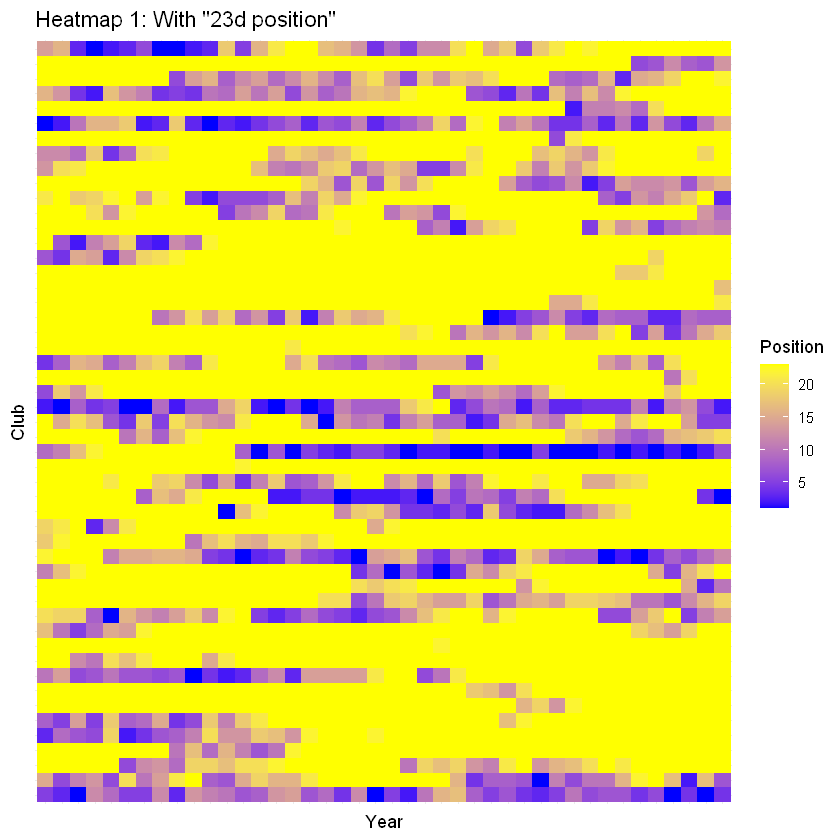

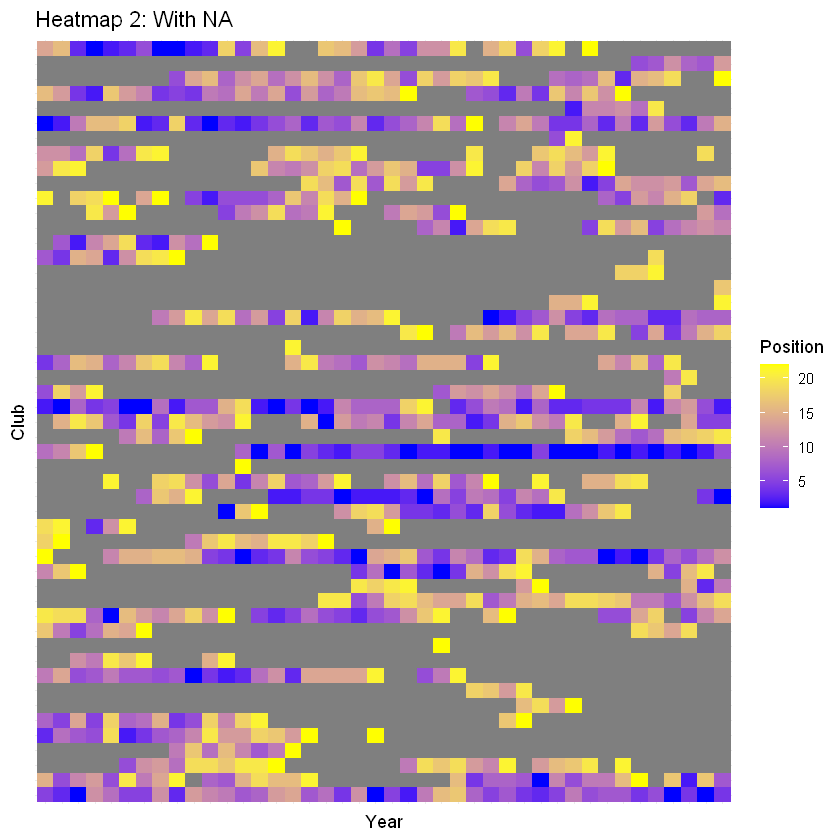

In [9]:
ggplot(df_full_23_long, aes(x = Year, y = Team, fill = Position)) +
  geom_tile() +
  labs(title = 'Heatmap 1: With "23d position"',
       x = "Year",
       y = "Club")+
scale_fill_gradient(
    low = "blue",      # Color for low values
    high = "yellow")+
theme_minimal() +
  theme(
    axis.text.x = element_blank(),  # Remove x-axis text
    axis.text.y = element_blank(),  # Remove y-axis text
    axis.ticks.x = element_blank(), # Remove x-axis ticks
    axis.ticks.y = element_blank()  # Remove y-axis ticks
  )

ggplot(df_full_NA_long, aes(x = Year, y = Team, fill = Position)) +
  geom_tile() +
  labs(title = "Heatmap 2: With NA",
       x = "Year",
       y = "Club")+
scale_fill_gradient(
    low = "blue",      # Color for low values
    high = "yellow")+
theme_minimal() +
  theme(
    axis.text.x = element_blank(),  # Remove x-axis text
    axis.text.y = element_blank(),  # Remove y-axis text
    axis.ticks.x = element_blank(), # Remove x-axis ticks
    axis.ticks.y = element_blank()  # Remove y-axis ticks
  )

In [10]:
# We can also calculate the average 
df_full_23 <- df_full_23 %>% select(2, 1, everything())
df_full_23[, 2:43] <- lapply(df_full_23[, 2:43], as.numeric)

In [11]:
changes <- c()
for (i in 2:42){
    increments <- abs(df_full_23[,i]-df_full_23[,i+1])
    increment_sum <- sum(increments)
    changes <- c(changes, increment_sum)
}

`geom_smooth()` using formula = 'y ~ x'


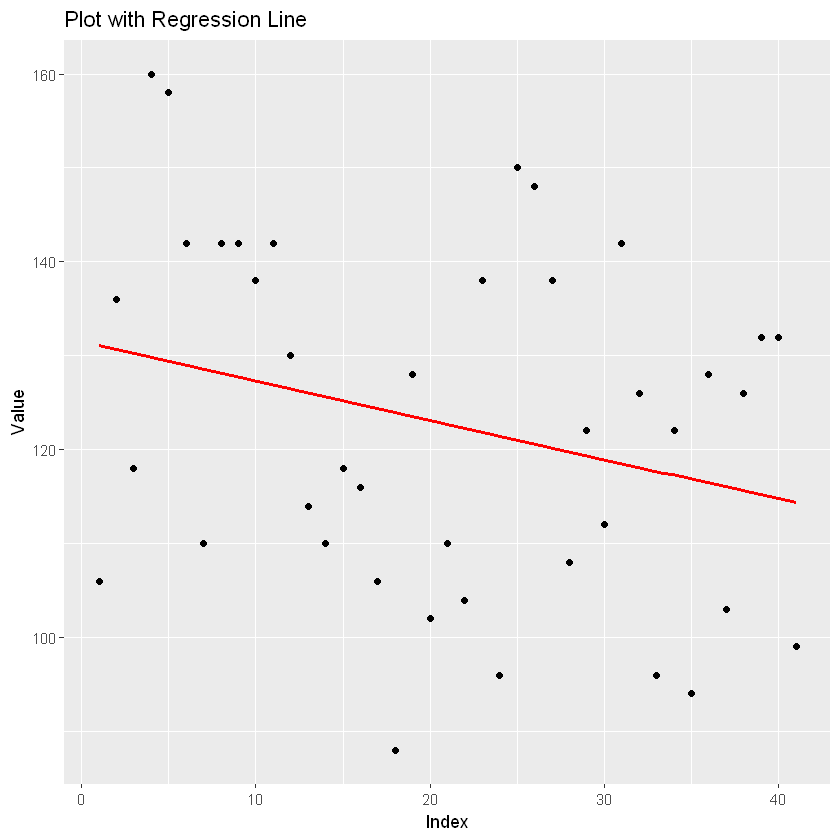

In [20]:
# Create a dataframe
df_cumu_change <- data.frame(x = 1:length(changes), y = changes)

# Create a line plot
ggplot(df_cumu_change, aes(x = x, y = y)) +
    geom_point() +  # Scatter plot
    geom_smooth(method = "lm", se = FALSE, color = "red") +  # Add regression line
    labs(title = "Plot with Regression Line", x = "Index", y = "Value")

In [13]:
SEA <- c("Brighton and Hove Albion",
"Southampton",
"Oxford United",
"Portsmouth",
"Reading",
"Wycombe Wanderers",
"Crawley Town",
"Gillingham",
"MK Dons",
"Aldershot Town",
"Dorking Wanderers",
"Eastleigh",
"Ebbsfleet United",
"Maidenhead United",
"Oxford City",
"Woking",
"Brighton & Hove Albion")

LDN <- c("Arsenal",
"Brentford",
"Chelsea",
"Crystal Palace",
"Fulham",
"Tottenham Hotspur",
"West Ham United",
"Millwall",
"Queens Park Rangers",
"Charlton Athletic",
"Leyton Orient",
"AFC Wimbledon",
"Sutton United",
"Barnet",
"Bromley",
"Dagenham and Redbridge",
"Wealdstone",
"Wimbledon")

NOW <- c("Burnley",
"Everton",
"Liverpool",
"Manchester City",
"Manchester United",
"Blackburn Rovers",
"Preston North End",
"Blackpool",
"Bolton Wanderers",
"Carlisle United",
"Fleetwood Town",
"Wigan Athletic",
"Accrington Stanley",
"Barrow",
"Crewe Alexandra",
"Morecambe",
"Salford City",
"Stockport County",
"Tranmere Rovers",
"Altrincham",
"Fylde",
"Oldham Athletic",
"Rochdale")

EAST <- c("Luton Town",
"Ipswich Town",
"Norwich City",
"Watford",
"Cambridge United",
"Peterborough",
"Stevenage",
"Colchester United",
"Boreham Wood",
"Southend United")

WMD <- c("Aston Villa",
"Wolverhampton Wanderers",
"Birmingham City",
"Coventry City",
"Stoke City",
"West Bromwich Albion",
"Burton Albion",
"Port Vale",
"Shrewsbury Town",
"Walsall",
"Kidderminster Harriers",
"Solihull Moors")

SWE <- c("Bournemouth",
"Bristol City",
"Plymouth Argyle",
"Bristol Rovers",
"Cheltenham Town",
"Exeter City",
"Swindon Town",
"Forest Green Rovers")

YOH <- c("Sheffield United",
"Huddersfield",
"Hull City",
"Leeds United",
"Rotherham",
"Sheffield Wednesday",
"Barnsley",
"Lincoln City",
"Bradford City",
"Doncaster Rovers",
"Grimsby Town",
"Harrogate Town",
"Halifax Town",
"York City",
"Huddersfield Town",
"Middlesbrough")

EWD <- c("Nottingham Forest",
"Leicester City",
"Derby County",
"Northampton Town",
"Mansfield Town",
"Notts County",
"Chesterfield")

NEA <- c("Newcastle United",
"Middlesborough",
"Sunderland",
"Gateshead",
"Hartlepool")

In [13]:
SEA <- c("Brighton and Hove Albion",
"Southampton",
"Oxford United",
"Portsmouth",
"Reading",
"Wycombe Wanderers",
"Crawley Town",
"Gillingham",
"MK Dons",
"Aldershot Town",
"Dorking Wanderers",
"Eastleigh",
"Ebbsfleet United",
"Maidenhead United",
"Oxford City",
"Woking",
"Brighton & Hove Albion")

LDN <- c("Arsenal",
"Brentford",
"Chelsea",
"Crystal Palace",
"Fulham",
"Tottenham Hotspur",
"West Ham United",
"Millwall",
"Queens Park Rangers",
"Charlton Athletic",
"Leyton Orient",
"AFC Wimbledon",
"Sutton United",
"Barnet",
"Bromley",
"Dagenham and Redbridge",
"Wealdstone",
"Wimbledon")

NOW <- c("Burnley",
"Everton",
"Liverpool",
"Manchester City",
"Manchester United",
"Blackburn Rovers",
"Preston North End",
"Blackpool",
"Bolton Wanderers",
"Carlisle United",
"Fleetwood Town",
"Wigan Athletic",
"Accrington Stanley",
"Barrow",
"Crewe Alexandra",
"Morecambe",
"Salford City",
"Stockport County",
"Tranmere Rovers",
"Altrincham",
"Fylde",
"Oldham Athletic",
"Rochdale")

EAST <- c("Luton Town",
"Ipswich Town",
"Norwich City",
"Watford",
"Cambridge United",
"Peterborough",
"Stevenage",
"Colchester United",
"Boreham Wood",
"Southend United")

WMD <- c("Aston Villa",
"Wolverhampton Wanderers",
"Birmingham City",
"Coventry City",
"Stoke City",
"West Bromwich Albion",
"Burton Albion",
"Port Vale",
"Shrewsbury Town",
"Walsall",
"Kidderminster Harriers",
"Solihull Moors")

SWE <- c("Bournemouth",
"Bristol City",
"Plymouth Argyle",
"Bristol Rovers",
"Cheltenham Town",
"Exeter City",
"Swindon Town",
"Forest Green Rovers")

YOH <- c("Sheffield United",
"Huddersfield",
"Hull City",
"Leeds United",
"Rotherham",
"Sheffield Wednesday",
"Barnsley",
"Lincoln City",
"Bradford City",
"Doncaster Rovers",
"Grimsby Town",
"Harrogate Town",
"Halifax Town",
"York City",
"Huddersfield Town",
"Middlesbrough")

EWD <- c("Nottingham Forest",
"Leicester City",
"Derby County",
"Northampton Town",
"Mansfield Town",
"Notts County",
"Chesterfield")

NEA <- c("Newcastle United",
"Middlesborough",
"Sunderland",
"Gateshead",
"Hartlepool")

In [14]:
df_full_23 <- df_full_23 %>%
  mutate(Region = case_when(
    Team %in% SEA ~ "SEA",
    Team %in% LDN ~ "LDN",
    Team %in% NOW ~ "NOW",
    Team %in% EAST ~ "EAST",
    Team %in% SWE ~ "SWE",
    Team %in% YOH ~ "YOH",
    Team %in% EWD ~ "EWD",
    Team %in% NEA ~ "NEA",
    Team %in% WMD ~ "WMD", 
    TRUE ~ "Other"  # Teams not found in any of the English regions
  ))

In [15]:
df_region <- df_full_23 %>%
    group_by(Region)
df_region

Team,1951,1952,1953,1954,1955,1956,1957,1958,1959,⋯,1984,1985,1986,1987,1988,1989,1990,1991,1992,Region
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Tottenham Hotspur,1,2,10,16,16,18,2,3,18,⋯,8,3,10,3,13,6,3,10,15,LDN
Manchester United,2,1,8,4,5,1,1,9,2,⋯,4,4,4,11,2,11,13,6,2,NOW
Blackpool,3,9,7,6,19,2,4,7,8,⋯,23,23,23,23,23,23,23,23,23,NOW
Newcastle United,4,8,16,15,8,11,17,19,11,⋯,23,14,11,17,8,20,23,23,23,NEA
Arsenal,5,3,1,12,9,5,5,12,3,⋯,6,7,7,4,6,1,4,1,4,LDN
Middlesbrough,6,18,13,21,23,23,23,23,23,⋯,23,23,23,23,23,18,23,23,23,YOH
Portsmouth,7,4,15,14,3,12,19,20,22,⋯,23,23,23,23,19,23,23,23,23,SEA
Bolton Wanderers,8,5,14,5,18,8,9,15,4,⋯,23,23,23,23,23,23,23,23,23,NOW
Liverpool,9,11,17,22,23,23,23,23,23,⋯,1,2,1,2,1,2,1,2,6,NOW


In [16]:
df_long <- df_full_23 %>%
  pivot_longer(cols = starts_with("19"), # assuming the years are column names like '1951', '1952', ..., '1992'
               names_to = "year", 
               values_to = "points")

# Now, we group by Region and calculate the number of rows where points are not 23 for each year
df_summary <- df_long %>%
  group_by(Region, year) %>%
  summarize(count_non_23 = sum(points != 23), .groups = "drop")

# Print the result
print(df_summary)

# A tibble: 420 × 3
   Region year  count_non_23
   <chr>  <chr>        <int>
 1 EAST   1951             0
 2 EAST   1952             0
 3 EAST   1953             0
 4 EAST   1954             0
 5 EAST   1955             0
 6 EAST   1956             1
 7 EAST   1957             1
 8 EAST   1958             1
 9 EAST   1959             1
10 EAST   1960             1
# ℹ 410 more rows


In [17]:
counts_by_region <- df_summary %>%
  group_by(Region) %>%
  summarize(count_vector = list(count_non_23)) %>%
  pull(count_vector)

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


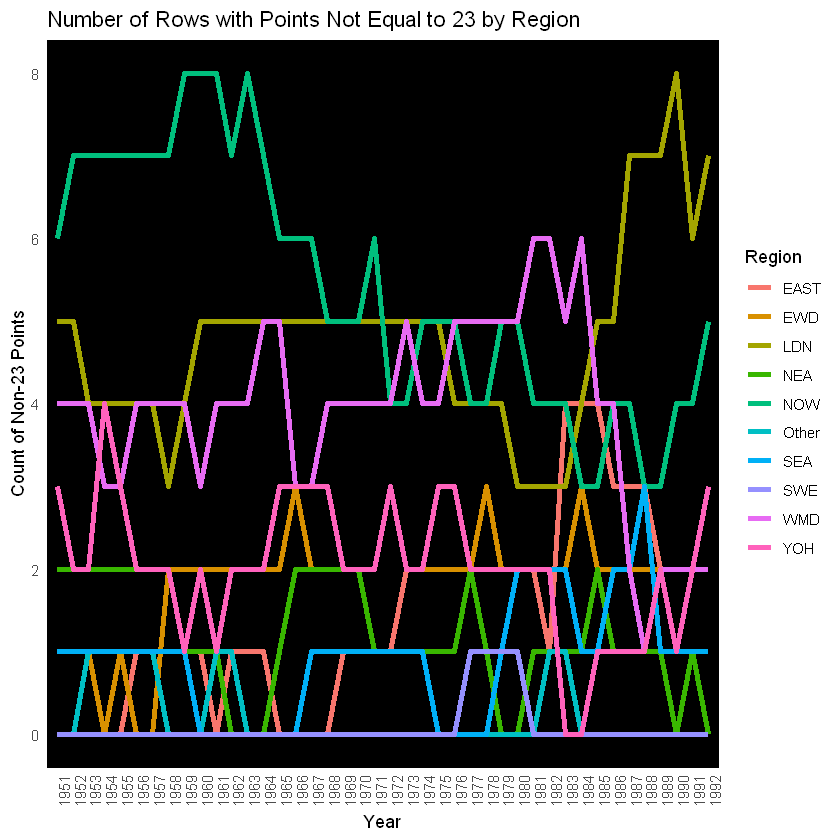

In [18]:
ggplot(df_summary, aes(x = year, y = count_non_23, color = Region, group = Region)) +
  geom_line(size = 1.5, linetype = "solid") +  # Increase line thickness
  labs(title = "Number of Rows with Points Not Equal to 23 by Region", 
       x = "Year", 
       y = "Count of Non-23 Points") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1),  # Rotate x-axis labels for readability
    panel.background = element_rect(fill = "black"),  # Set background color
    panel.grid = element_blank()  # Remove gridlines
  )